In [146]:
import importlib
import sys
import os
import glob
import time
import cv2
#import h5py
import traceback

import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl
import matplotlib.gridspec as gridspec

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil
import auxiliary as aux
import plotting as putil

In [251]:
util.set_sns_style(style='dark', min_fontsize=8)
%matplotlib notebook
rootdir = util.get_rootdir()
rootdir

'/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data'

In [56]:
#rootdir = '/Volumes/Julie/2p-data'
rootdir = '/mnt/minerva/2p-data'
# -------------------------------------------------
date = 20230822 #20230725 #20230822 #20230822
flynum = 3
# -------------------------------------------------
# get directories
flyid = 'fly{}'.format(flynum)
session = str(date)
sessdir = os.path.join(rootdir, session)
print(sessdir)
behavior_dir = os.path.join(sessdir, 'behavior')
logdir = os.path.join(sessdir, 'behavior') #'logfiles')
videodir = os.path.join(sessdir, 'behavior') #'videos')
neural_dir = os.path.join(sessdir, 'raw')
# face cam data -----------------------------------
# NOTE: .mp4 is compressed, prob easier to work with
# NOTE2: sometimes, >1 video...
all_vid_fpaths = sorted(glob.glob(os.path.join(sessdir, 
                                'behavior', '{}*{}'.format(session, flyid))), key=util.natsort)
# behavior data -----------------------------------
logfiles = aux.get_logs_for_fly_date(date, flynum, logdir)

# DESTDIR -------------------------------------------
figid = '{}-{}'.format(session, flyid)
print(figid)

destdir = os.path.join(rootdir, session, 'processed')
if not os.path.exists(destdir):
    os.makedirs(destdir)
figdir = os.path.join(destdir, 'figures')
if not os.path.exists(figdir):
    os.makedirs(figdir)

/mnt/minerva/2p-data/20230822
20230822-fly3


In [4]:
xvar = 'ft_posx'
yvar = 'ft_posy'
default_cond = 'tap'
df0 = aux.logfiles_to_dataframe(logfiles, flyid)
df0 = aux.merge_blocks(df0, fps=120)

/mnt/minerva/2p-data/20230822/behavior/20230822-153812_P1_activation_fly3_000.log
... WARNING: rel_time has skips, only taking up to 1st time point
/mnt/minerva/2p-data/20230822/behavior/20230822-160657_P1_activation_fly3_001.log


/home/julianarhee/Repositories/plume-tracking/auxiliary.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blocknum'] = 0


/mnt/minerva/2p-data/20230822/behavior/20230822-162257_P1_activation_fly3_002.log
/mnt/minerva/2p-data/20230822/behavior/20230822-162500_P1_activation_fly3_003.log
... WARNING: rel_time has skips, only taking up to 1st time point
/mnt/minerva/2p-data/20230822/behavior/20230822-163923_P1_activation_fly3_004.log


/home/julianarhee/Repositories/plume-tracking/auxiliary.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blocknum'] = 0


<IPython.core.display.Javascript object>


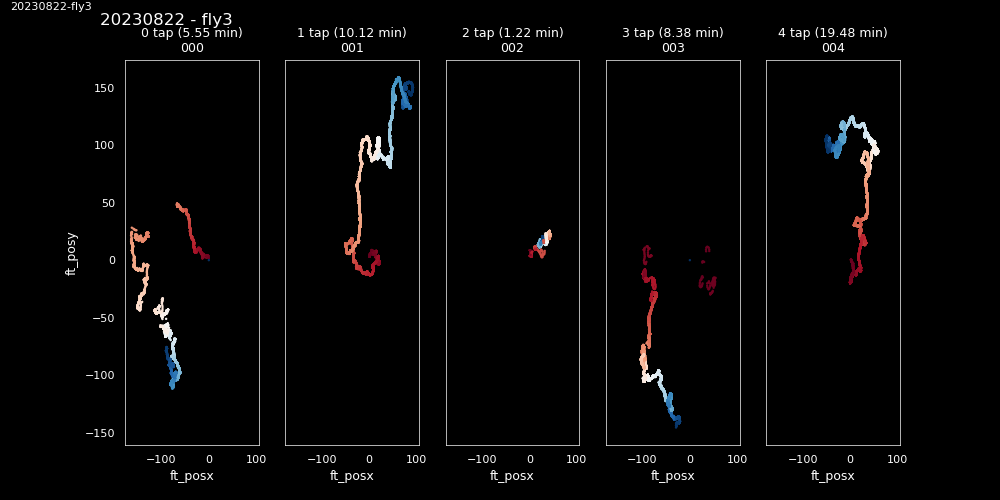

20230822-163923_P1_activation_fly3_004
tracking_merged-bouts_by-time


In [360]:
#curr_trials = df0[['filename', 'blocknum']].drop_duplicates().dropna().shape[0]
n_trials = df0['filename'].dropna().nunique()
max_nblocks = int(df0['blocknum'].max()+1)
fig, axn = pl.subplots(1, n_trials, figsize=(10, 5), sharex=True, sharey=True)
    
for fi, (fn, df_) in enumerate(df0.sort_values(by='filename').groupby('filename')):
    colors = sns.color_palette('cubehelix', n_colors=df_['blocknum'].nunique())
    ax=axn[fi]
    dur_min = df_['rel_time'].max() / 60.
    sns.scatterplot(data=df_, x=xvar, y=yvar, ax=ax, palette='RdBu',
                   edgecolor='none', s=3 , legend=0, hue='rel_time') #color=colors[ci])
                    #hue_norm=mpl.colors.Normalize(vmin=0, vmax=1800))
    curr_cond = df_['condition'].unique()[0]
    ax.set_title('{} {} ({:.2f} min)\n{}'.format(fi, curr_cond, dur_min, \
                                                  fn.split('_')[-1]))
    #ax.set_aspect('equal')
#util.label_figure(fig, '{}'.format(os.path.split(fn)[-1]))
figname = '{}'.format(fn)
print(fn)
    
fig.text(0.1, 0.95, '{} - {}'.format(date, flyid), fontsize=12)

util.label_figure(fig, figid)
figname = 'tracking_merged-bouts_by-time'
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))
print(figname)

In [361]:
filenames = sorted(df0['filename'].dropna().unique(), key=util.natsort)
for fi, fn in enumerate(filenames):
    print(fi, fn)

0 20230822-153812_P1_activation_fly3_000
1 20230822-160657_P1_activation_fly3_001
2 20230822-162257_P1_activation_fly3_002
3 20230822-162500_P1_activation_fly3_003
4 20230822-163923_P1_activation_fly3_004


# Select 1 file

In [362]:
logfn = filenames[1]
print(logfn)
df = df0[df0['filename']==logfn].copy()
cfg = butil.load_experiment_config(os.path.join(logdir, logfn))
print(cfg)
print(logfn)

20230822-160657_P1_activation_fly3_001
{'name': 'P1_activation', 'datestr': '20230822-160657_P1_activation_fly3_001', 'experiment': {'pre_air_time': 0, 'max_total_airflow': 0, 'strip_width': 10000, 'strip_spacing': 0, 'percent_odor': 0, 'source_distance': 10000, 'reinforce': True, 'y_thresh': 500, 'pre_led_time': 15, 'led_intensity': 100, 'led_color': 'red', 'window_len': 5, 'pulse_period': 1, 'acquisition_rate': 60}, 'camera': {'experimenter': 'jyr', 'savedir': '/home/julianarhee/Videos/basler-tests', 'codec': 'libx264', 'basler_options': {'Width': 960, 'Height': 600, 'Framerate': 120.0, 'Exposure': 8000.0, 'Gain': 1, 'Uncompressed': False}, 'cams': {'fictrac': {'type': 'Basler', 'master': False, 'serial': 22297042, 'options': {'AcquisitionMode': 'Continuous', 'ExposureAuto': 'Off', 'ExposureMode': 'Timed', 'ExposureTime': 1000.0, 'BinningVerticalMode': 'Sum', 'BinningHorizontalMode': 'Sum', 'BinningVertical': 2, 'BinningHorizontal': 2, 'Height': 600, 'Width': 960, 'CenterX': True, 'C

## Get corresponding CAM data

In [370]:
logfn

'20230822-160657_P1_activation_fly3_001'

In [371]:
# frame rate of FT
fps_behav= cfg['experiment']['acquisition_rate']
# frame rate of SIDECAM
camdir0 = aux.get_videodir_from_tstamp(logfn, all_vid_fpaths)
cfg_cam0 = aux.load_cam_config(camdir0)
cam0 = 'flyleft'
fps_cam0 = cfg_cam0['cams'][cam0]['options']['AcquisitionFrameRate']
# path to SIDECAM vid
cam0_fpaths = glob.glob(os.path.join(camdir0, '*.avi'))
cam0_fpath = cam0_fpaths[0]
print(cam0_fpath)

/mnt/minerva/2p-data/20230822/behavior/20230822-160623_fly3/flyleft_20230822160623_00000.avi


<IPython.core.display.Javascript object>


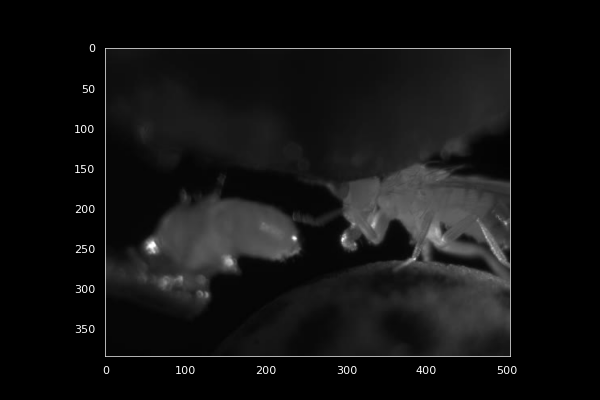

In [372]:
# FACECAM video
start_frame=61
vcap = cv2.VideoCapture(cam0_fpath)
vcap.set(1, start_frame)
ret, frame = vcap.read()

fig, ax = pl.subplots()
ax.imshow(frame)

## Load manual taps

In [373]:
cam0_fpath

'/mnt/minerva/2p-data/20230822/behavior/20230822-160623_fly3/flyleft_20230822160623_00000.avi'

In [457]:
import re

In [508]:
cam0_fname = os.path.splitext(os.path.split(cam0_fpath)[-1])[0]
print(cam0_fname)
manual_taps_fp = glob.glob(os.path.join(sessdir, 'processed', 'taps_{}.md'.format(cam0_fname)))[0]
print(manual_taps_fp)
lines= []
with open(manual_taps_fp) as f:
    for line in f:
        if line.startswith('#') or line=='':
            pass
        else:
            lines.append(line.strip('\n').strip())

flyleft_20230822160623_00000
/mnt/minerva/2p-data/20230822/processed/taps_flyleft_20230822160623_00000.md


In [509]:
taps = pd.DataFrame(data=lines, columns=['string'])
taps['certain'] = [0 if '?' in l else 1 for l in taps['string']]
taps['foreleg'] = [re.search(r'\((.*?)\)', l).group(1) if re.search(r'\((.*?)\)', l) is not None else np.nan for l in taps['string']]
taps['frame_str'] = [l.split('(')[0].strip() for l in taps['string']]
taps['start_frame'] = np.array([int(l.split('-')[0].strip()) if '?' not in l else int(l.strip().split('-')[-1][0:-1]) for l in taps['frame_str']]) - 1
taps['end_frame'] = np.array([int(l.split('-')[-1].strip()) if '?' not in l else int(l.strip().split('-')[-1][0:-1]) for l in taps['frame_str']]) - 1
taps['taplevel'] = None
for i, l in taps.iterrows():
    if not isinstance(l['foreleg'], str):
        continue
    if l['certain']==0:
        taps.loc[i, 'taplevel'] = 1
        continue
    else:
        if 'tip' in l['foreleg']:
            taps.loc[i, 'taplevel'] = 2
        elif 'full' in l['foreleg']:
            taps.loc[i, 'taplevel'] = 4
        elif 'half' in l['foreleg']:
            taps.loc[i, 'taplevel'] = 3


#### plot

<IPython.core.display.Javascript object>


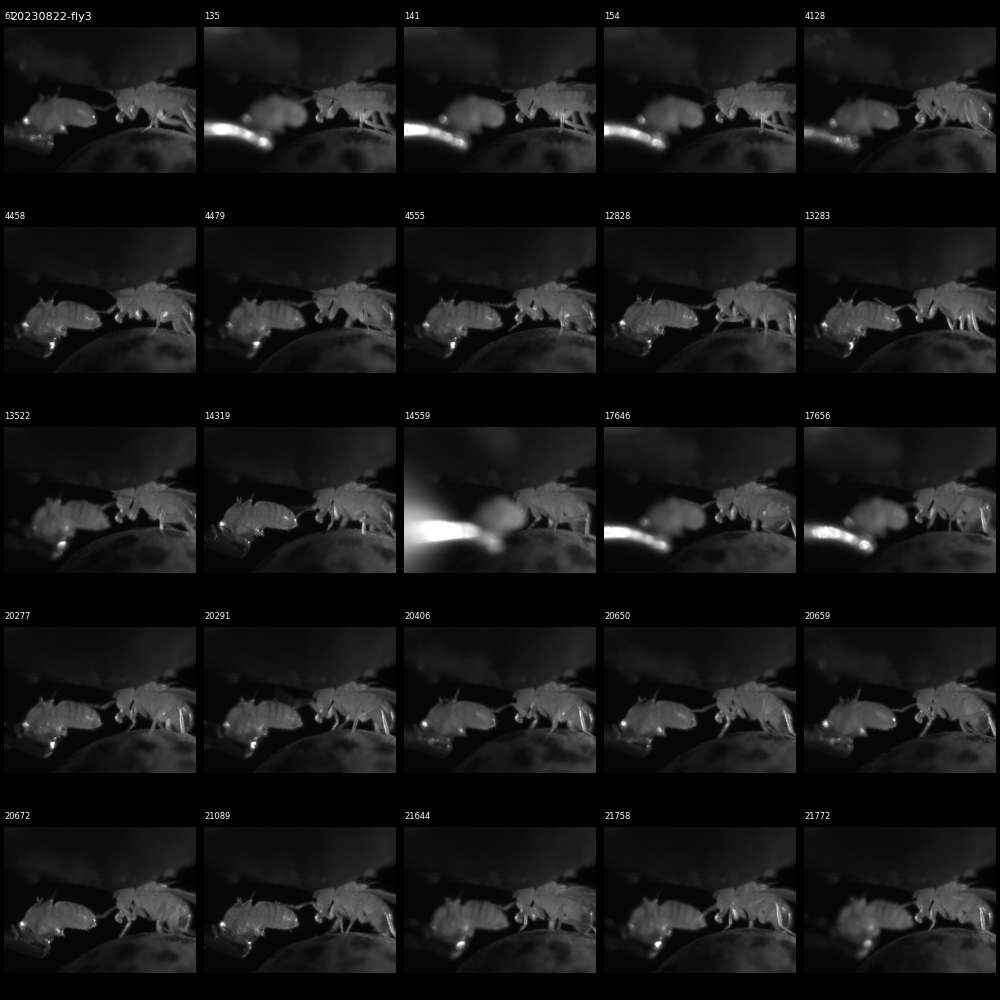

/tmp/ipykernel_201603/1625488705.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for ai, v in enumerate(certaintaps[0:nr*nc]):


In [510]:
certaintaps = taps[taps['certain']==1]['start_frame']
nr, nc = (5,5)
fig, axn = pl.subplots(nr, nc, figsize=(nr*2, nc*2), constrained_layout=True)
for ai, v in enumerate(certaintaps[0:nr*nc]):
    ax=axn.flat[ai]
    vcap.set(1, v)
    ret, frame = vcap.read()
    ax.imshow(frame)
    ax.axis('off')
    ax.set_title(v, loc='left', fontsize=6)
util.label_figure(fig, figid)
figname = 'example-taps_{}'.format(logfn)
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))

In [511]:
taps['taplevel'].unique()

array([2, 4, 1, None, 3], dtype=object)

<IPython.core.display.Javascript object>


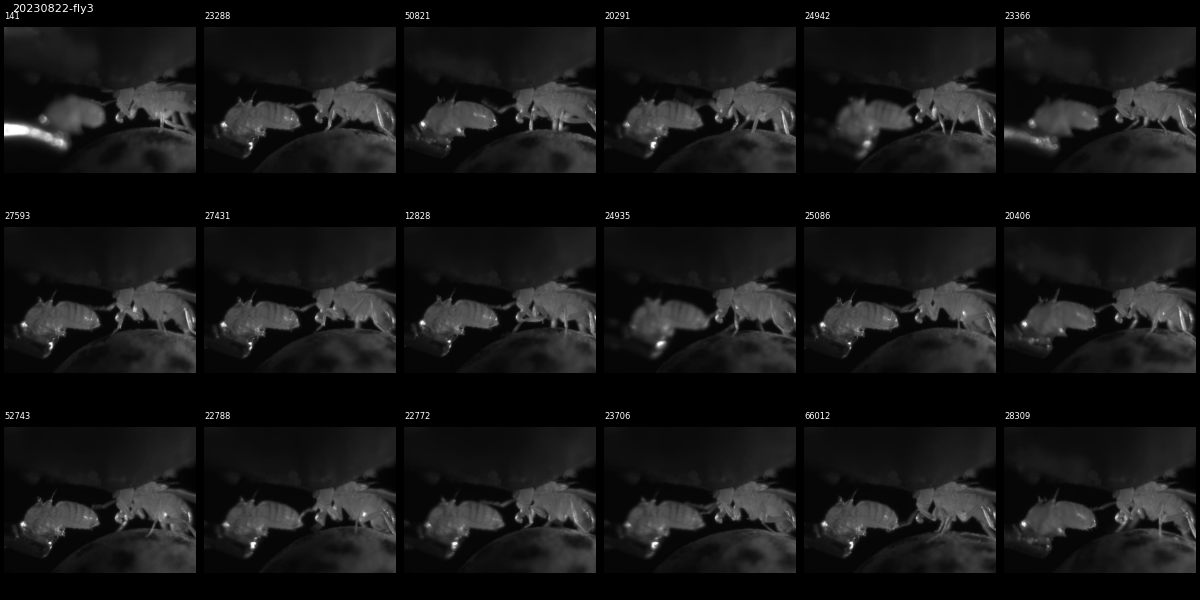

In [512]:
# full_ = taps[taps['taplevel']==4]['start_frame']
# half_ = taps[taps['level']==3]['start_frame']
full_ = np.array([13525, 20293, 36131, 49043, 67894]) - 1
half_ = np.array([12829, 20280, 27432, 34960, 50203]) - 1
tip_ = np.array([]) - 1
nr, nc = (3,6)
fig, axn = pl.subplots(nr, nc, figsize=(nc*2, nr*2), constrained_layout=True)
for ri, tl in enumerate([4, 3, 2]):
    currtaps = taps[taps['taplevel']==tl]['start_frame'].sample(n=6).values
    for ci, ct in enumerate(currtaps):
        ax=axn[ri, ci]
        vcap.set(1, ct)
        ret, frame = vcap.read()
        ax.imshow(frame)
        ax.axis('off')
        ax.set_title(ct, loc='left', fontsize=6)
util.label_figure(fig, figid)
figname = 'example-taps-bylevel_{}'.format(logfn)
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))

In [502]:
currtaps

NameError: name 'currtaps' is not defined

# Cam metadata

In [429]:
cam0_meta_fp = glob.glob(os.path.join(camdir0, '*metadata.h5'))[0]
cam0 = aux.h5_to_df(cam0_meta_fp)
cam0['rel_time'] = cam0['timestamp'] - cam0['timestamp'].iloc[0]
print(cam0.shape)
cam0.head()

(72831, 7)


,cputime,framecount,frameid,serial,sestime,timestamp,rel_time
0,1.692735e+09,1,1,24516213,33.640661,33.625133,0.000000
1,1.692735e+09,2,2,24516213,33.655799,33.640307,0.015173
2,1.692735e+09,3,3,24516213,33.674781,33.648642,0.023509
3,1.692735e+09,4,4,24516213,33.682519,33.656977,0.031844
4,1.692735e+09,5,5,24516213,33.690014,33.665313,0.040179


In [430]:
df['rel_time']

0          0.000000
1          0.014089
2          0.030752
3          0.047593
4          0.063781
            ...    
36367    606.975257
36368    606.993042
36369    607.008484
36370    607.025629
36371    607.043368
Name: rel_time, Length: 36372, dtype: float64

# Align CAM and FICTRAC

<IPython.core.display.Javascript object>


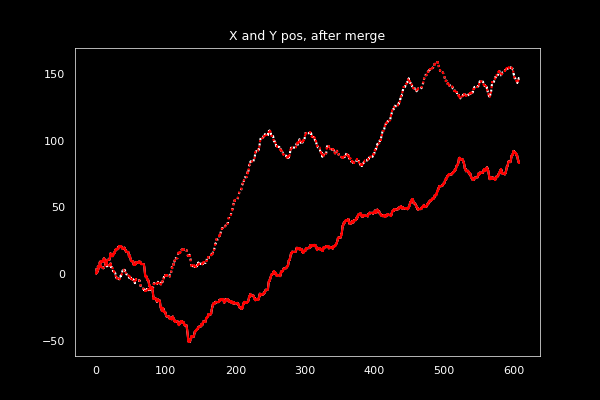

In [431]:
xpos_interp = np.interp(cam0['rel_time'].values, df['rel_time'].values, df['ft_posx'].values)
ypos_interp = np.interp(cam0['rel_time'].values, df['rel_time'].values, df['ft_posy'].values)
tsec_cam = cam0['rel_time'].values

fig, ax = pl.subplots()
ax.plot(df['rel_time'].values, df['ft_posx'].values, 'w')
ax.plot(df['rel_time'].values, df['ft_posy'].values, color='w', linestyle=':')

ax.plot(tsec_cam, xpos_interp, 'r')
ax.plot(tsec_cam, ypos_interp, 'r', linestyle=':')

ax.set_title('X and Y pos, after merge')
pl.subplots_adjust(hspace=0.5)


In [432]:
combined = cam0.copy()
combined['ft_posx'] = xpos_interp
combined['ft_posy'] = ypos_interp

In [436]:
taps.head()

,string,certain,foreleg,frame_str,start_frame,end_frame
0,62 (tip),1,tip,62,61,61
1,136-137 (full),1,full,136-137,135,136
2,142-143 (full),1,full,142-143,141,142
3,155 (full),1,full,155,154,154
4,1458? (tip),0,tip,1458?,1457,1457


In [438]:
taps[taps['foreleg']=='4779']

,string,certain,foreleg,frame_str,start_frame,end_frame
9,4779?,0,4779,4779?,4778,4778


In [433]:
combined['tap'] = 0
combined.loc[combined['framecount'].isin(certaintaps), 'tap'] = 2 
combined.loc[combined['framecount'].isin(maybetaps), 'tap'] = 1

<IPython.core.display.Javascript object>


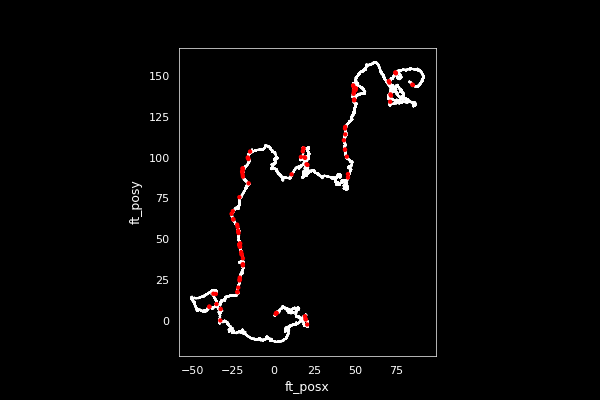

In [434]:
fig, ax = pl.subplots()
sns.scatterplot(data=combined, x='ft_posx', y='ft_posy', ax=ax,
               edgecolor='none', color='w', s=2)
sns.scatterplot(data=combined[combined['tap']==2], x='ft_posx', y='ft_posy',  ax=ax,
               edgecolor='none', s=10, color='r')
ax.set_aspect('equal')

# Load neural traces

In [115]:
run_index = [i for i, v in enumerate(logfiles) if logfn in v][0]
print(run_index)

1


In [116]:
sessiondir = os.path.join(rootdir, str(session))
all_neural_fpaths = sorted(glob.glob(os.path.join(sessiondir, 
                                'raw', '{}*{}*_Ch2.tif'.format(str(session), flyid))), key=util.natsort)
neural_fpath = all_neural_fpaths[run_index]
print(neural_fpath)
assert os.path.exists(neural_fpath), "2p path does not exist: {}".format(neural_fpath)

/mnt/minerva/2p-data/20230822/raw/20230822-1535_fly3-001_Ch2.tif


In [201]:
tifname = os.path.splitext(os.path.split(neural_fpath)[-1])[0]
print(tifname)
neuraltraces = aux.load_neural_traces_from_csv(tifname, rootdir=rootdir)
neuraltraces.head()

20230822-1535_fly3-001_Ch2


,Slice,Mean,hemi
0,1,90.2715,left
1,2,91.8609,left
2,3,89.1656,left
3,4,93.6093,left
4,5,95.0397,left


In [202]:
neuraltraces['time'] = neuraltraces['Slice']/fps_neural
neuraltraces['time'] = neuraltraces['time']-neuraltraces['time'].iloc[0]

In [208]:
fps_neural = 10
neuraltraces['time'] = neuraltraces['Slice']/fps_neural
neuraltraces['time'] = neuraltraces['time']-neuraltraces['time'].iloc[0]

for hemi, df_ in neuraltraces.groupby('hemi'):
    t = df_['Mean'].copy()
    t_sub = util.subtract_rolling_mean(t, 500)
    rollmean = util.subtract_rolling_mean(t, 500, return_mean_only=True)
    neuraltraces.loc[df_.index, 'Mean_detrended'] = t_sub
    neuraltraces.loc[df_.index, 'Mean_basesub'] = df_['Mean'] - rollmean.mean()
    neuraltraces.loc[df_.index, 'Mean_dff'] = (df_['Mean'] - rollmean.mean()) / rollmean.mean()
    
neuraltraces.head()

,Slice,Mean,hemi,time,Mean_detrended,Mean_basesub,Mean_dff
0,1,90.2715,left,0.0,-2.278049,-5.362493,-0.050727
1,2,91.8609,left,0.1,4.934212,1.856007,0.017557
2,3,89.1656,left,0.2,3.689631,0.624207,0.005905
3,4,93.6093,left,0.3,3.094377,0.034807,0.000329
4,5,95.0397,left,0.4,1.332709,-1.720093,-0.016271


# Combine data

In [330]:
fulldf = combined[combined['rel_time']<=neuraltraces['time'].max()].copy()

In [331]:
for hemi, tr in neuraltraces.groupby('hemi'):
    tr_interp = np.interp(fulldf['rel_time'], tr['time'], tr['Mean_dff'])
    fulldf['neural_{}'.format(hemi)] = tr_interp

<IPython.core.display.Javascript object>


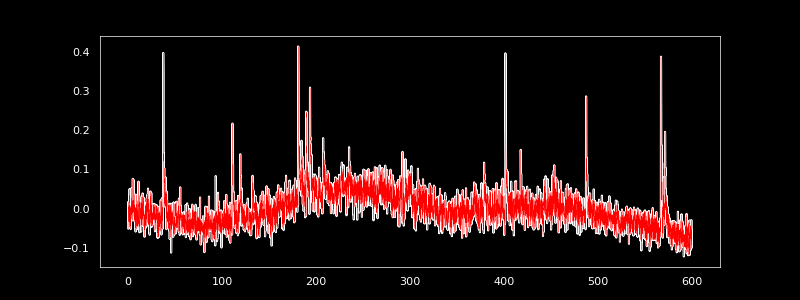

In [332]:
fig, ax = pl.subplots(figsize=(8,3))
ax.plot(neuraltraces[neuraltraces['hemi']=='left']['time'], neuraltraces[neuraltraces['hemi']=='left']['Mean_dff'], 'w')
ax.plot(fulldf['rel_time'], fulldf['neural_left'], 'r', lw=0.2)


In [334]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

<IPython.core.display.Javascript object>


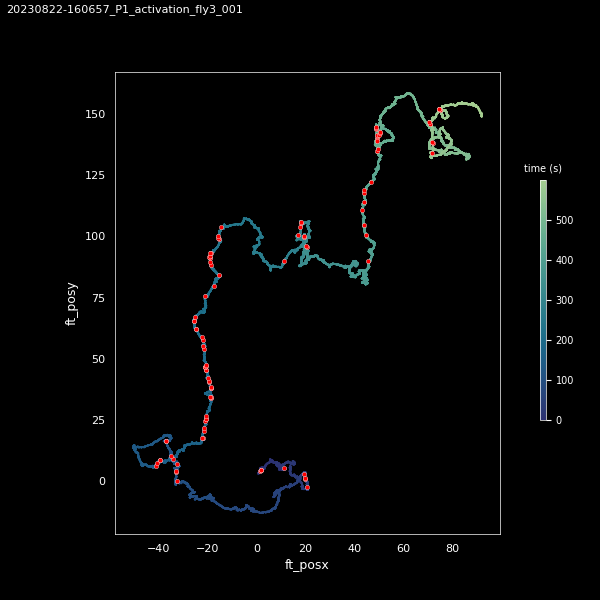

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


In [335]:
cmap='crest_r'
huevar='rel_time'
norm = mpl.colors.Normalize(vmin=fulldf[huevar].min(), vmax=fulldf[huevar].max())
fig, ax = pl.subplots(figsize=(6,6), constrained_layout=False)
# Trajectory
sc = sns.scatterplot(data=fulldf, x='ft_posx', y='ft_posy', ax=ax,
               edgecolor='none', color='w', s=2, hue=huevar, palette=cmap, norm=norm, legend=0)
sns.scatterplot(data=fulldf[fulldf['tap']==2], x='ft_posx', y='ft_posy',  ax=ax,
               edgecolor='w', s=10, color='r')
putil.colorbar_from_mappable(ax, norm, cmap=cmap, hue_title='time (s)', axes=[0.9, 0.3, 0.01, 0.4])
ax.set_aspect('equal')
ax.set_anchor('N')

util.label_figure(fig, logfn)
figname = 'trajectory_with_taps_{}'.format(logfn)
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))

In [265]:
figdir

'/mnt/minerva/2p-data/20230822/processed/figures'

In [355]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

<IPython.core.display.Javascript object>


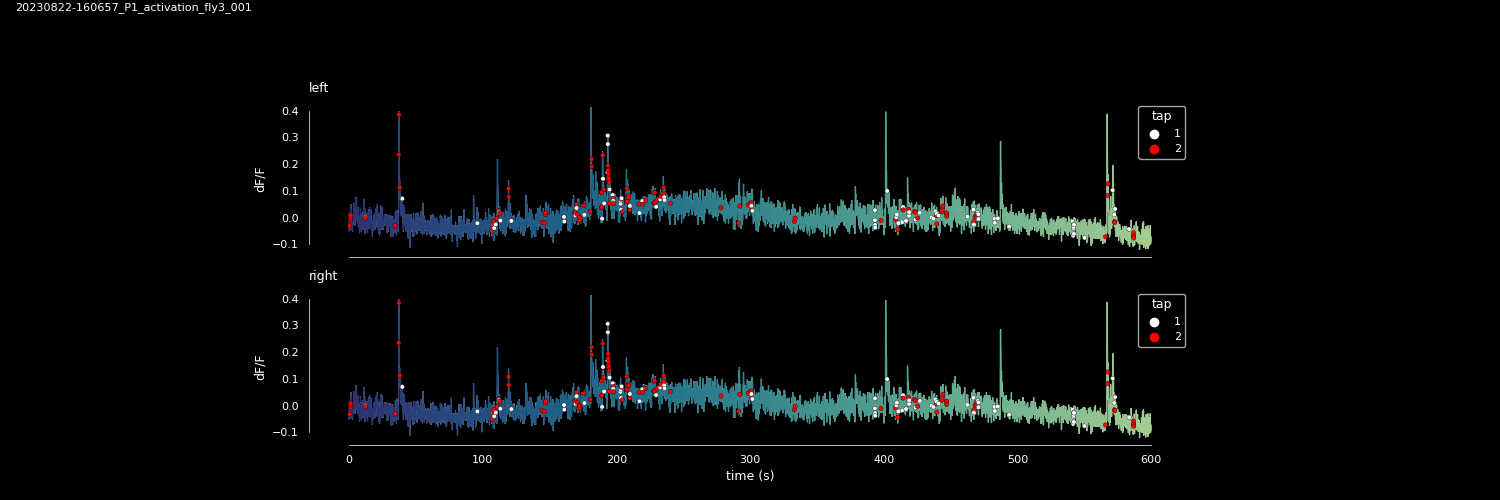

In [359]:
fig, axn = pl.subplots(2, 1, figsize=(15,5), sharex=True, sharey=True) #, constrained_layout=True)
for ai, hemi in enumerate(['left', 'right']):
    ax=axn[ai]
    ax.set_title(hemi, loc='left')
    ax.plot(fulldf['rel_time'], fulldf['neural_{}'.format(hemi)], color='w', lw=0.5)
    putil.add_colored_lines(fulldf, ax=ax, xvar='rel_time', yvar='neural_{}'.format(hemi), hue_var='rel_time', cmap=cmap, norm=norm)

    sns.scatterplot(data=fulldf[fulldf['tap']>0], x='rel_time', y='neural_{}'.format(hemi), 
                    hue='tap', palette={1: 'w', 2: 'r'}, ax=ax, zorder=40, edgecolor='k', s=10)
    ax.set_aspect(200)
    ax.set_ylabel('dF/F')
pl.subplots_adjust(left=0.05, right=0.95, top=0.8)

ax.set_xlabel('time (s)')


util.label_figure(fig, logfn)
figname = 'neuraltraces_with_taps_{}'.format(logfn)
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))
sns.despine(trim=True)